Binary 6/6 (MT + NU) C)

mRNA localization using binary classification (mitochondria/nucleus) (part 3): basic model with: <br> 
<br>
a) Method 6: no feature selection and class weights accounted for <br>
b) Method 7: with feature importance-based feature selection (SHAP), w/ threshold > 0  and class weights accounted for<br>

In [18]:
import pandas as pd
from catboost import CatBoostClassifier
from catboost import Pool
import matplotlib.pyplot as plt
import numpy as np
import shap

In [2]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, average_precision_score, roc_auc_score, precision_recall_curve, roc_curve, auc, f1_score, classification_report

In [3]:
#data initialization

#Mitochondria (label = 2)
MT_train = pd.read_csv("../../Data/InputData/MT_iLearnfeatvalues_train_CSV.csv")
MT_test = pd.read_csv("../../Data/InputData/MT_iLearnfeatvalues_test_CSV.csv")

#Nucleus (label = 3)
NU_train = pd.read_csv("../../Data/InputData/NU_iLearnfeatvalues_train_CSV.csv")
NU_test = pd.read_csv("../../Data/InputData/NU_iLearnfeatvalues_test_CSV.csv")


print("MT TRAIN, TEST SHAPE:", MT_train.shape, ",", MT_test.shape)
print("NU TRAIN, TEST SHAPE:", NU_train.shape, ",", NU_test.shape)

MT TRAIN, TEST SHAPE: (280, 1026) , (70, 1026)
NU TRAIN, TEST SHAPE: (640, 1026) , (160, 1026)


In [4]:
###### NEXT STEP #######
#Merge training files for binary classification (CP+ER, CP+MT, CP+NU, ER+MT, ER+NU, MT+NU)
#Merge testing files same way

#How to merge: 
# - https://saturncloud.io/blog/how-to-merge-two-csv-files-into-one-with-pandas-by-id/
# or pd.concat


In [5]:

#Group 6: MT + NU

frames_MN_tra =[MT_train, NU_train]
frames_MN_tes =[MT_test, NU_test]

MT_NU_train = pd.concat(frames_MN_tra)
MT_NU_test = pd.concat(frames_MN_tes)

In [6]:

print("\nMT + NU TRAIN, TEST SHAPE:", MT_NU_train.shape, ",", MT_NU_test.shape)


MT + NU TRAIN, TEST SHAPE: (920, 1026) , (230, 1026)


In [7]:
MT_NU_test.head(73)

,#,label,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,mRNALoc_18808#856050|2|testing,2,0.001747,0.001747,0.005240,0.005240,0.001747,0.000873,0.002620,0.001747,...,0.000873,0.001747,0.001747,0.001747,0.001747,0.001747,0.001747,0.000873,0.001747,0.003493
1,mRNALoc_18516#852314|2|testing,2,0.010536,0.004390,0.004390,0.006146,0.003512,0.001756,0.000878,0.001756,...,0.000000,0.002634,0.003512,0.000878,0.003512,0.000878,0.001756,0.002634,0.004390,0.000000
2,mRNALoc_18612#853304|2|testing,2,0.004390,0.001756,0.002634,0.001756,0.003512,0.001756,0.000000,0.001756,...,0.000000,0.000000,0.002634,0.001756,0.000878,0.000000,0.005268,0.000878,0.002634,0.009658
3,mRNALoc_18679#854170|2|testing,2,0.001765,0.003530,0.002648,0.000000,0.001765,0.000883,0.000000,0.002648,...,0.000883,0.000000,0.000000,0.000883,0.001765,0.001765,0.002648,0.002648,0.000883,0.000883
4,mRNALoc_18546#852637|2|testing,2,0.000000,0.000887,0.001775,0.000000,0.001775,0.002662,0.000887,0.000000,...,0.002662,0.000887,0.002662,0.000887,0.004437,0.000887,0.002662,0.004437,0.002662,0.002662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,mRNALoc_18370#850602|2|testing,2,0.007919,0.003394,0.007919,0.002262,0.007919,0.003394,0.000000,0.004525,...,0.001131,0.001131,0.000000,0.000000,0.005656,0.001131,0.002262,0.002262,0.001131,0.002262
69,mRNALoc_18476#851819|2|testing,2,0.010181,0.003394,0.005656,0.001131,0.002262,0.003394,0.000000,0.001131,...,0.001131,0.004525,0.003394,0.002262,0.001131,0.001131,0.001131,0.001131,0.003394,0.003394
0,mRNALoc_4836#21374|3|testing,3,0.001632,0.002176,0.001632,0.002176,0.001632,0.001088,0.000544,0.001088,...,0.000000,0.004353,0.000544,0.000544,0.001632,0.002176,0.003264,0.002720,0.002720,0.004897
1,mRNALoc_7063#26002|3|testing,3,0.002176,0.001088,0.003264,0.000544,0.001088,0.000544,0.000000,0.001088,...,0.000544,0.001632,0.001088,0.002176,0.001088,0.000000,0.001088,0.001088,0.001088,0.000544


In [8]:
#FOR MT+NU
noname_MN_train = MT_NU_train.drop("#", axis="columns")
noname_MN_test = MT_NU_test.drop("#", axis="columns")


MT_NU_X_train = noname_MN_train.drop("label", axis="columns")
MT_NU_y_train = noname_MN_train["label"]

MT_NU_X_test = noname_MN_test.drop("label", axis="columns")
MT_NU_y_test = noname_MN_test["label"]

print("MT + NU X train:", MT_NU_X_train.shape)
print("MT + NU y train:", MT_NU_y_train.shape)
print("MT + NU X test:", MT_NU_X_test.shape)
print("MT + NU y test:", MT_NU_y_test.shape)

MT + NU X train: (920, 1024)
MT + NU y train: (920,)
MT + NU X test: (230, 1024)
MT + NU y test: (230,)


In [9]:
# Create data pools for feature importance/selection for MT + NU

MN_feature_names = list(MT_NU_X_train.columns)
print("Number of features:", len(MN_feature_names))

MN_train_pool = Pool(MT_NU_X_train, MT_NU_y_train, feature_names=MN_feature_names)

MN_test_pool = Pool(MT_NU_X_test, MT_NU_y_test)

print("*Mitochondria, Nucleus Pools created")

Number of features: 1024
*Mitochondria, Nucleus Pools created


    Method 6: Basic model with class imbalance taken into account (but without feature importance/selection/hyperparameter tuning)

In [10]:
MN_binary_model = CatBoostClassifier(loss_function="MultiClass", auto_class_weights="Balanced")

In [11]:
#Fit model to MN data

MN_binary_model.fit(MN_train_pool)

Learning rate set to 0.078791
0:	learn: 0.6507238	total: 195ms	remaining: 3m 14s
1:	learn: 0.6061246	total: 341ms	remaining: 2m 50s
2:	learn: 0.5728662	total: 476ms	remaining: 2m 38s
3:	learn: 0.5394654	total: 619ms	remaining: 2m 34s
4:	learn: 0.5060663	total: 743ms	remaining: 2m 27s
5:	learn: 0.4764510	total: 869ms	remaining: 2m 24s
6:	learn: 0.4512525	total: 1s	remaining: 2m 21s
7:	learn: 0.4272923	total: 1.14s	remaining: 2m 20s
8:	learn: 0.4061618	total: 1.27s	remaining: 2m 19s
9:	learn: 0.3839882	total: 1.4s	remaining: 2m 18s
10:	learn: 0.3635706	total: 1.52s	remaining: 2m 16s
11:	learn: 0.3449837	total: 1.65s	remaining: 2m 15s
12:	learn: 0.3273205	total: 1.78s	remaining: 2m 14s
13:	learn: 0.3128878	total: 1.91s	remaining: 2m 14s
14:	learn: 0.2984823	total: 2.02s	remaining: 2m 13s
15:	learn: 0.2853835	total: 2.15s	remaining: 2m 12s
16:	learn: 0.2737345	total: 2.28s	remaining: 2m 11s
17:	learn: 0.2624965	total: 2.4s	remaining: 2m 11s
18:	learn: 0.2525658	total: 2.52s	remaining: 2m 1

In [12]:
#Check parameters used in this model fit

MN_bin_params = MN_binary_model.get_all_params()
print("Basic model parameters:", MN_bin_params)

Basic model parameters: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [2, 3], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'class_weights': [2.2857143878936768, 1], 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'Balanced', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'Mult

In [13]:
#Prediction using X_test
MN_y_pred = MN_binary_model.predict(MT_NU_X_test)

#Predication probability

MN_y_prob = MN_binary_model.predict_proba(MT_NU_X_test)

In [15]:
# Calculate F1 score and get classification report

print("Model 6: Basic model w/ class imbalance accounted for - Mitochondria & nucleus")

MN_cr = classification_report(MT_NU_y_test, MN_y_pred, digits=3)
print(MN_cr)

print('Accuracy score: ', accuracy_score(MT_NU_y_test, MN_y_pred))


MN_f1 = f1_score(MT_NU_y_test, MN_y_pred, average='macro')
print(f"\nF1 Score: {MN_f1}")
# print('Roc auc score : ', roc_auc_score(MT_NU_y_test, MN_y_prob))

Model 6: Basic model w/ class imbalance accounted for - Mitochondria & nucleus
              precision    recall  f1-score   support

           2      0.707     1.000     0.828        70
           3      1.000     0.819     0.900       160

    accuracy                          0.874       230
   macro avg      0.854     0.909     0.864       230
weighted avg      0.911     0.874     0.878       230

Accuracy score:  0.8739130434782608

F1 Score: 0.8643730047377944


In [16]:
# Confusion matrix for selected data

print("real values shape:", MT_NU_y_test.shape)
print("prediction shape:", MN_y_pred.shape)

MN_y_pred_fl = MN_y_pred
print("flattened prediction values shape:", MN_y_pred_fl.ravel().shape, "\n")

MN_cMatrix = confusion_matrix(MT_NU_y_test, MN_y_pred_fl)
print(MN_cMatrix)

real values shape: (230,)
prediction shape: (230, 1)
flattened prediction values shape: (230,) 

[[ 70   0]
 [ 29 131]]


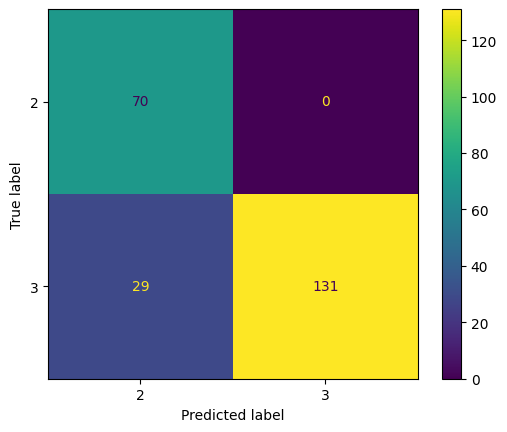

In [17]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=MN_cMatrix, display_labels=MN_binary_model.classes_)
disp.plot()
plt.show()

*************

    Method 7: Modelling using feature selection based on feature importance values (with get_feature_importances type = "ShapValues"), threshold > 0 with class weights accounted for

In [19]:
#SHAP explainer to explain CatBoost output
explainer = shap.TreeExplainer(MN_binary_model)

In [20]:
#SHAP values for X_train
MN_shap_values = explainer.shap_values(MT_NU_X_train)

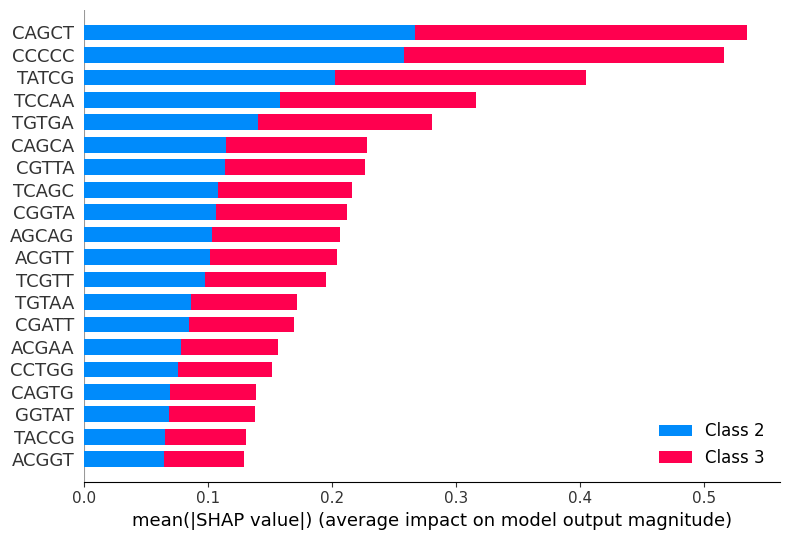

In [23]:
shap.summary_plot(MN_shap_values, MT_NU_X_train, plot_size=0.2, class_names=["Class 2", "Class 3"])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


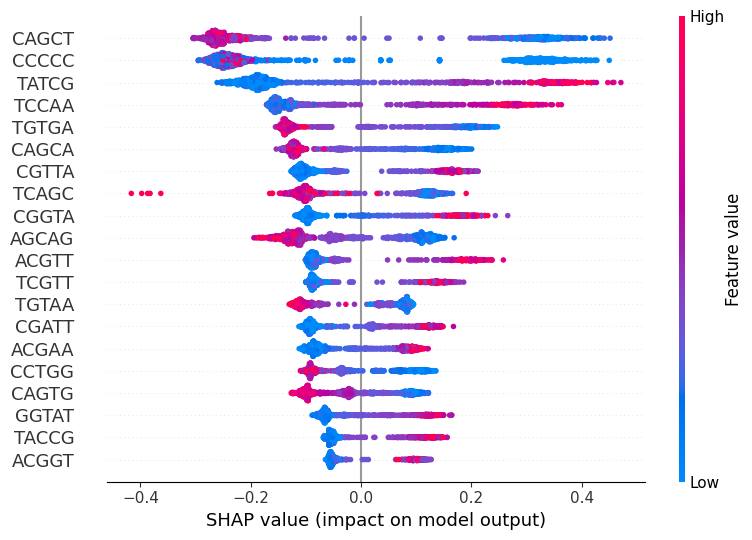

In [26]:
shap.summary_plot(MN_shap_values[0], MT_NU_X_train, plot_size=0.2)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


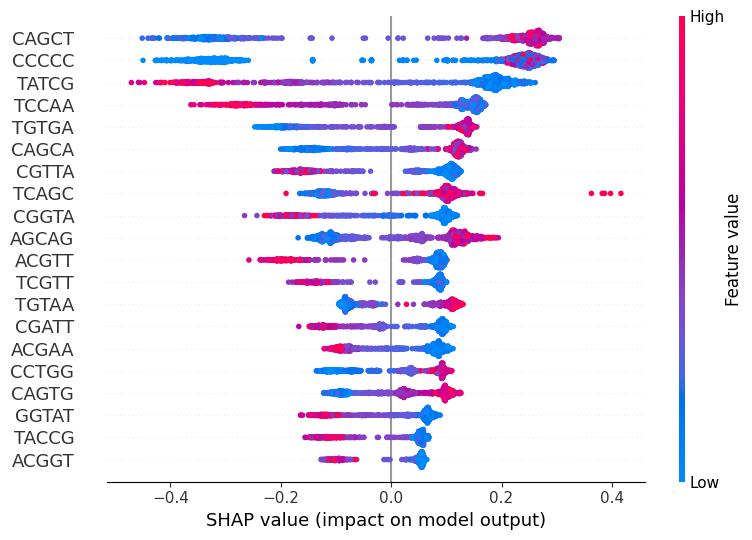

In [27]:
shap.summary_plot(MN_shap_values[1], MT_NU_X_train, plot_size=0.2)

In [28]:
shap_df = pd.DataFrame(MN_shap_values[0], columns=MT_NU_X_train.columns)


In [29]:
MN_shap_FI = (shap_df[shap_df>0]
                                .mean()
                                .sort_values(ascending=False)
                                .reset_index()
                                .rename(columns={'index':'Feature Id', 0:'Importances'})
                                # .head()
                        )

In [30]:
#Classifier results with MN_feature_importance

In [33]:
# Show only feature importances above 0

MN_SHAP_thres_chosen = MN_shap_FI[MN_shap_FI['Importances'] > 0]
MN_shap_num_chosen = len(MN_SHAP_thres_chosen)

print(MN_SHAP_thres_chosen)

print("\nAmount of features with importnace above 0 (selected features):", MN_shap_num_chosen)

    Feature Id  Importances
0        CCCCC     0.316970
1        CAGCT     0.315740
2        TATCG     0.256299
3        TCCAA     0.215736
4        ACGTT     0.184071
..         ...          ...
763      GCTCC     0.000030
764      AGGTC     0.000024
765      GGACT     0.000019
766      AGTGA     0.000011
767      TGCGG     0.000007

[768 rows x 2 columns]

Amount of features with importnace above 0 (selected features): 768


In [35]:
print("Sum of total feature importances: ", sum(MN_shap_FI.Importances))
print("Sum of feature importances > 0: ", sum(MN_SHAP_thres_chosen.Importances))

Sum of total feature importances:  nan
Sum of feature importances > 0:  8.744539246573781


In [36]:
# Select features with importance values above 0.1

MN_shap_selected_feat = MN_shap_FI[:MN_shap_num_chosen]['Feature Id'].tolist()

# print(MN_shap_selected_feat)

In [37]:
MT_NU_X_train.shape

(920, 1024)

In [38]:
# See original training set

MT_NU_X_train.head(826)


,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,AAAGA,AAAGC,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,0.003945,0.001255,0.002690,0.002152,0.001435,0.000359,0.001076,0.001435,0.001973,0.001435,...,0.001614,0.001255,0.003407,0.001435,0.001435,0.001973,0.001435,0.001435,0.002869,0.001435
1,0.006502,0.002956,0.001970,0.003941,0.004138,0.001576,0.001379,0.001379,0.002562,0.001970,...,0.000591,0.001970,0.001576,0.000394,0.001773,0.001773,0.004729,0.003350,0.002365,0.014778
2,0.010090,0.001682,0.003784,0.002943,0.001892,0.001892,0.000420,0.001472,0.003153,0.002523,...,0.000210,0.002312,0.000841,0.001472,0.001892,0.001682,0.001051,0.002102,0.000841,0.003153
3,0.002139,0.001528,0.002139,0.003362,0.001528,0.001222,0.000917,0.001528,0.003056,0.001528,...,0.000917,0.001222,0.003667,0.002751,0.002139,0.002751,0.000306,0.002751,0.002751,0.002445
4,0.001737,0.000000,0.000579,0.002895,0.000579,0.000000,0.000000,0.002895,0.002316,0.001158,...,0.002895,0.005790,0.002316,0.001737,0.002895,0.004632,0.002316,0.005211,0.002895,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541,0.006428,0.004326,0.004203,0.005562,0.005686,0.002349,0.000618,0.002101,0.003832,0.003214,...,0.000247,0.001607,0.001360,0.000742,0.000865,0.002225,0.001731,0.001112,0.001112,0.000618
542,0.004331,0.002475,0.002598,0.002970,0.002103,0.000619,0.000000,0.001732,0.002351,0.001237,...,0.000247,0.001361,0.002598,0.001980,0.001485,0.001609,0.002846,0.001361,0.002351,0.003464
543,0.005940,0.001237,0.002722,0.002970,0.001361,0.001732,0.000124,0.002104,0.002599,0.001980,...,0.000247,0.002475,0.000990,0.001361,0.002351,0.002351,0.001856,0.001609,0.002970,0.003217
544,0.002353,0.001734,0.001981,0.002353,0.001734,0.001362,0.000619,0.001362,0.003096,0.001238,...,0.000371,0.001238,0.001238,0.001114,0.001610,0.001610,0.001486,0.001486,0.001362,0.000743


In [39]:
#Create training set with selected features 

MN_X_train_shap_selected = MT_NU_X_train[MN_shap_selected_feat]
MN_X_train_shap_selected.head()

,CCCCC,CAGCT,TATCG,TCCAA,ACGTT,TGTGA,CGTTA,CGGTA,TCGTT,CAGCA,...,GATTG,TGAAC,CTCAT,GGAAG,GACTG,GCTCC,AGGTC,GGACT,AGTGA,TGCGG
0,0.00000,0.001076,0.000717,0.000897,0.000717,0.000000,0.000717,0.000359,0.000717,0.002152,...,0.000538,0.000897,0.000897,0.002331,0.000717,0.000359,0.000538,0.001793,0.000897,0.000538
1,0.00197,0.000788,0.000394,0.002759,0.000788,0.000985,0.000985,0.000788,0.000591,0.003153,...,0.001379,0.000394,0.001576,0.001379,0.000788,0.001379,0.000394,0.000985,0.001970,0.000000
2,0.00021,0.001051,0.001051,0.002523,0.001261,0.002312,0.000420,0.000000,0.000000,0.001472,...,0.000841,0.000420,0.001682,0.002312,0.001261,0.001051,0.001261,0.000841,0.001261,0.000420
3,0.00000,0.000306,0.000611,0.001222,0.001528,0.000917,0.000917,0.000917,0.000611,0.000611,...,0.001834,0.000611,0.001528,0.001834,0.001528,0.000306,0.001528,0.000917,0.001528,0.000306
4,0.00000,0.001737,0.000579,0.005211,0.002316,0.000000,0.001158,0.002316,0.001737,0.000579,...,0.002895,0.000000,0.000000,0.001158,0.000000,0.000579,0.001158,0.000000,0.000000,0.000000


In [40]:
# Check whether columns in new training set are the same featues are the ones selected
if(list(MN_X_train_shap_selected.columns) == MN_shap_selected_feat):
    print("Selected and column features are the same; properly selected");
else:
    print("Features not selected properly")

Selected and column features are the same; properly selected


In [41]:
# Check whether number of variables/sequences of training set is the same as number of labels (no change should have been made to the sequences (rows), only to the features (columns)) 
print("Shape of X_train_selected (number of variables/sequences):", MN_X_train_shap_selected.shape)
print("Shape of y_train (number of labels):", MT_NU_y_train.shape)

Shape of X_train_selected (number of variables/sequences): (920, 768)
Shape of y_train (number of labels): (920,)


In [42]:
# Create pool object for selected feature data
print("Original number of features:", len(MN_feature_names), "\n Number of selected features:", len(MN_shap_selected_feat))

MN_shap_selected_train_pool = Pool(MN_X_train_shap_selected, MT_NU_y_train, feature_names=MN_shap_selected_feat)

Original number of features: 1024 
 Number of selected features: 768


In [43]:
#Create new model for data with selected features
MN_FIFS_shap_model = CatBoostClassifier(loss_function="MultiClass", auto_class_weights="Balanced")

# Fit new data into same model as before

MN_FIFS_shap_model.fit(MN_shap_selected_train_pool)

Learning rate set to 0.078791
0:	learn: 0.6484275	total: 237ms	remaining: 3m 56s
1:	learn: 0.6041078	total: 350ms	remaining: 2m 54s
2:	learn: 0.5678578	total: 460ms	remaining: 2m 32s
3:	learn: 0.5313343	total: 577ms	remaining: 2m 23s
4:	learn: 0.4992643	total: 678ms	remaining: 2m 14s
5:	learn: 0.4679832	total: 803ms	remaining: 2m 13s
6:	learn: 0.4416707	total: 911ms	remaining: 2m 9s
7:	learn: 0.4182579	total: 1.02s	remaining: 2m 6s
8:	learn: 0.3971397	total: 1.12s	remaining: 2m 2s
9:	learn: 0.3782008	total: 1.23s	remaining: 2m 1s
10:	learn: 0.3610310	total: 1.33s	remaining: 1m 59s
11:	learn: 0.3434442	total: 1.43s	remaining: 1m 57s
12:	learn: 0.3268627	total: 1.52s	remaining: 1m 55s
13:	learn: 0.3110474	total: 1.62s	remaining: 1m 54s
14:	learn: 0.2967490	total: 1.71s	remaining: 1m 52s
15:	learn: 0.2827253	total: 1.81s	remaining: 1m 51s
16:	learn: 0.2706639	total: 1.91s	remaining: 1m 50s
17:	learn: 0.2608864	total: 2s	remaining: 1m 48s
18:	learn: 0.2495221	total: 2.09s	remaining: 1m 48s

In [44]:
#Check parameters used in this model fit

MN_FIFS_shap_params = MN_FIFS_shap_model.get_all_params()
print("Basic model parameters:", MN_FIFS_shap_params)

Basic model parameters: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [2, 3], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'class_weights': [2.2857143878936768, 1], 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'Balanced', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'Mult

In [45]:
#Prediction using X_test only for selected features data
MN_FIFS_shap_y_pred = MN_FIFS_shap_model.predict(MT_NU_X_test)

#Predication probability for selected features data

MN_FIFS_shap_y_prob = MN_FIFS_shap_model.predict_proba(MT_NU_X_test)

In [46]:
# Calculate F1 score and get classification report

print("Model 7: Feature selection (SHAP) w/ threshold > 0 \nand class imbalance accounted for - Mitochondria & nucleus")

print("\nNumber of chosen features:", len(MN_shap_selected_feat), "\n")

MN_FIFS_shap_cr = classification_report(MT_NU_y_test, MN_FIFS_shap_y_pred, digits=3)
print(MN_FIFS_shap_cr)

print('Accuracy score: ', accuracy_score(MT_NU_y_test, MN_FIFS_shap_y_pred))

MN_FIFS_shap_f1 = f1_score(MT_NU_y_test, MN_FIFS_shap_y_pred, average='macro')
print(f"\nF1 Score: {MN_FIFS_shap_f1}")
# print('Roc auc score : ', roc_auc_score(MT_NU_y_test, MN_FIFS_shap_y_prob))

Model 7: Feature selection (SHAP) w/ threshold > 0 
and class imbalance accounted for - Mitochondria & nucleus

Number of chosen features: 768 

              precision    recall  f1-score   support

           2      0.700     1.000     0.824        70
           3      1.000     0.812     0.897       160

    accuracy                          0.870       230
   macro avg      0.850     0.906     0.860       230
weighted avg      0.909     0.870     0.874       230

Accuracy score:  0.8695652173913043

F1 Score: 0.8600405679513184


In [47]:
# Confusion matrix for selected data

print("real values shape:", MT_NU_y_test.shape)
print("prediction shape:", MN_FIFS_shap_y_pred.shape)

MN_FIFS_shap_y_pred_fl = MN_FIFS_shap_y_pred
print("flattened prediction values shape:", MN_FIFS_shap_y_pred_fl.ravel().shape, "\n")

MN_FIFS_shap_cMatrix = confusion_matrix(MT_NU_y_test, MN_FIFS_shap_y_pred_fl)
print(MN_FIFS_shap_cMatrix)

real values shape: (230,)
prediction shape: (230, 1)
flattened prediction values shape: (230,) 

[[ 70   0]
 [ 30 130]]


*********
<br>
*********

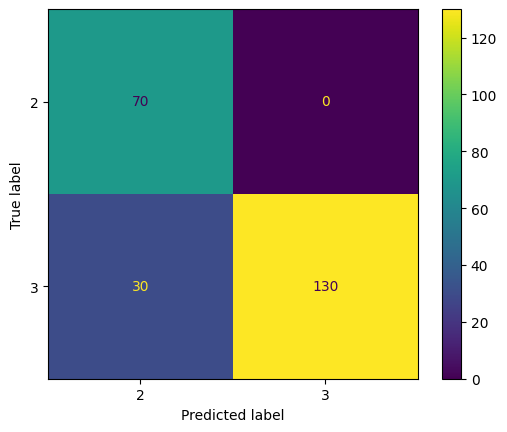

In [48]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=MN_FIFS_shap_cMatrix, display_labels=MN_FIFS_shap_model.classes_)
disp.plot()
plt.show()

    Method 2: Feature importance-based feature selection

In [16]:
#Feature importances for CM pair

MN_feat_importances = MN_binary_model.get_feature_importance(prettified=True)
MN_feat_importances.head(100)

,Feature Id,Importances
0,CAGCT,5.465171
1,TATCG,4.989385
2,CCCCC,4.832921
3,CGGTA,2.354264
4,AGCAG,2.233666
...,...,...
95,ATTAC,0.163596
96,CGGAG,0.163151
97,TTGAC,0.162780
98,CCTCA,0.162048


In [17]:
# Show only feature importances above 0.1

threshold_chosen_features = MN_feat_importances[MN_feat_importances['Importances'] >= 0.1]
num_chosen_features = len(threshold_chosen_features)

print(threshold_chosen_features)

print("\nAmount of features with importnace above 0.1 (selected features):", num_chosen_features)

    Feature Id  Importances
0        CAGCT     5.465171
1        TATCG     4.989385
2        CCCCC     4.832921
3        CGGTA     2.354264
4        AGCAG     2.233666
..         ...          ...
147      GTGGC     0.103993
148      AATCT     0.102435
149      ATAGG     0.102391
150      CTTCA     0.101765
151      TACTA     0.101350

[152 rows x 2 columns]

Amount of features with importnace above 0.1 (selected features): 152


In [19]:
print("Sum of total feature importances: ", sum(MN_feat_importances.Importances))
print("Sum of feature importances >=0.1: ", sum(threshold_chosen_features.Importances))

Sum of total feature importances:  100.00000000000014
Sum of feature importances >=0.1:  78.64458181545339


In [20]:
# Select features with importance values above 0.1

MN_selected_feat = MN_feat_importances[:num_chosen_features]['Feature Id'].tolist()

print(MN_selected_feat)

['CAGCT', 'TATCG', 'CCCCC', 'CGGTA', 'AGCAG', 'TCCAA', 'TCAGC', 'CGTTA', 'TGTGA', 'ACGTT', 'CAGTG', 'CAGCA', 'TCGTT', 'CAGCC', 'CCCAG', 'TACCG', 'GGCCT', 'CCTCC', 'CCAGC', 'GGTAT', 'TTCAA', 'CTCAG', 'TTACG', 'CGATT', 'TGGTA', 'CGATA', 'TCGAA', 'CTATT', 'TCGAT', 'AGCCC', 'ACGAA', 'CACAG', 'GGAGC', 'TACGT', 'GGTAA', 'AGGAG', 'ACGAT', 'GTGTG', 'CAATT', 'ATCGT', 'GCCTG', 'CCATT', 'GCAGT', 'CTGAG', 'ATTGG', 'CAGGG', 'CCCCT', 'TAACG', 'TACGA', 'GGATC', 'CATTG', 'AACGA', 'AGCAC', 'TGCAG', 'GGAGG', 'TGTCG', 'GAGGA', 'GCACA', 'CCTGC', 'TACGG', 'GGCAG', 'AGTGT', 'AGCCT', 'ACGGT', 'TCCCC', 'CTCTG', 'TGACG', 'ATGTG', 'TATGG', 'GGAGA', 'CGTTT', 'CGTAT', 'ATTGA', 'TCTGA', 'CGGTC', 'ATACG', 'TTCGA', 'CCCTC', 'CACAC', 'CGTTG', 'TCGAC', 'CCAGG', 'AGCTG', 'GCAGC', 'GCGCG', 'CGAAT', 'CCCGC', 'GAAGA', 'GCTCT', 'TTATC', 'GCTCG', 'CCGGG', 'TTTCG', 'CGAAA', 'GACGA', 'ATTAC', 'CGGAG', 'TTGAC', 'CCTCA', 'TGTAA', 'CTGTG', 'ACCGT', 'CAGGA', 'TGCAC', 'GCCAG', 'CAGTC', 'CGTAA', 'TCTGG', 'CAGGC', 'TGTAT', 'ACTAA', 

In [21]:
MT_NU_X_train.shape

(920, 1024)

In [22]:
# See original training set

MT_NU_X_train.head(283)


,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,AAAGA,AAAGC,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,0.003945,0.001255,0.002690,0.002152,0.001435,0.000359,0.001076,0.001435,0.001973,0.001435,...,0.001614,0.001255,0.003407,0.001435,0.001435,0.001973,0.001435,0.001435,0.002869,0.001435
1,0.006502,0.002956,0.001970,0.003941,0.004138,0.001576,0.001379,0.001379,0.002562,0.001970,...,0.000591,0.001970,0.001576,0.000394,0.001773,0.001773,0.004729,0.003350,0.002365,0.014778
2,0.010090,0.001682,0.003784,0.002943,0.001892,0.001892,0.000420,0.001472,0.003153,0.002523,...,0.000210,0.002312,0.000841,0.001472,0.001892,0.001682,0.001051,0.002102,0.000841,0.003153
3,0.002139,0.001528,0.002139,0.003362,0.001528,0.001222,0.000917,0.001528,0.003056,0.001528,...,0.000917,0.001222,0.003667,0.002751,0.002139,0.002751,0.000306,0.002751,0.002751,0.002445
4,0.001737,0.000000,0.000579,0.002895,0.000579,0.000000,0.000000,0.002895,0.002316,0.001158,...,0.002895,0.005790,0.002316,0.001737,0.002895,0.004632,0.002316,0.005211,0.002895,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,0.004355,0.000871,0.003484,0.005226,0.003484,0.000000,0.000000,0.000871,0.006098,0.003484,...,0.001742,0.004355,0.003484,0.002613,0.000000,0.002613,0.002613,0.006098,0.003484,0.007840
279,0.011354,0.001747,0.004367,0.006114,0.003493,0.000873,0.000873,0.001747,0.005240,0.002620,...,0.000000,0.000873,0.003493,0.000873,0.000873,0.000873,0.001747,0.000873,0.001747,0.003493
0,0.006391,0.001389,0.003334,0.001111,0.001389,0.000834,0.000556,0.000556,0.003056,0.000556,...,0.000000,0.000556,0.001389,0.000278,0.001389,0.001111,0.001111,0.000556,0.001945,0.005835
1,0.000000,0.000000,0.000000,0.001450,0.000000,0.000725,0.000000,0.000000,0.000725,0.000000,...,0.000000,0.000725,0.003626,0.001450,0.001450,0.000725,0.000725,0.000725,0.001450,0.000000


In [23]:
#Create training set with selected features 

MN_X_train_selected = MT_NU_X_train[MN_selected_feat]
MN_X_train_selected.head()

,CAGCT,TATCG,CCCCC,CGGTA,AGCAG,TCCAA,TCAGC,CGTTA,TGTGA,ACGTT,...,TCTGC,TGTGC,AATTG,TGGGT,AGACG,GTGGC,AATCT,ATAGG,CTTCA,TACTA
0,0.001076,0.000717,0.00000,0.000359,0.001435,0.000897,0.000897,0.000717,0.000000,0.000717,...,0.000897,0.000897,0.002152,0.000538,0.001614,0.000897,0.000538,0.000538,0.000897,0.002152
1,0.000788,0.000394,0.00197,0.000788,0.003350,0.002759,0.000788,0.000985,0.000985,0.000788,...,0.001379,0.001379,0.000985,0.000197,0.000985,0.000591,0.001773,0.000394,0.001379,0.000788
2,0.001051,0.001051,0.00021,0.000000,0.002312,0.002523,0.001472,0.000420,0.002312,0.001261,...,0.002943,0.000841,0.000631,0.000841,0.000631,0.001472,0.000631,0.000000,0.000631,0.000631
3,0.000306,0.000611,0.00000,0.000917,0.000917,0.001222,0.000306,0.000917,0.000917,0.001528,...,0.000611,0.000611,0.002445,0.001528,0.000306,0.000611,0.000917,0.000611,0.001528,0.000917
4,0.001737,0.000579,0.00000,0.002316,0.000579,0.005211,0.000579,0.001158,0.000000,0.002316,...,0.000000,0.000579,0.002316,0.003474,0.000579,0.000579,0.001158,0.000000,0.000579,0.001158


In [24]:
# Check whether columns in new training set are the same featues are the ones selected
if(list(MN_X_train_selected.columns) == MN_selected_feat):
    print("Selected and column features are the same; properly selected");
else:
    print("Features not selected properly")

Selected and column features are the same; properly selected


In [26]:
# Check whether number of variables/sequences of training set is the same as number of labels (no change should have been made to the sequences (rows), only to the features (columns)) 
print("Shape of X_train_selected (number of variables/sequences):", MN_X_train_selected.shape)
print("Shape of y_train (number of labels):", MT_NU_y_train.shape)

Shape of X_train_selected (number of variables/sequences): (920, 152)
Shape of y_train (number of labels): (920,)


In [27]:
# Create pool object for selected feature data
print("Original number of features:", len(MN_feature_names), "\n Number of selected features:", len(MN_selected_feat))

MN_selected_train_pool = Pool(MN_X_train_selected, MT_NU_y_train, feature_names=MN_selected_feat)

Original number of features: 1024 
 Number of selected features: 152


In [28]:
#Create new model for data with selected features
MN_FIFS_model = CatBoostClassifier(iterations=500, learning_rate = 0.1, depth= 5, random_seed=0)

# Fit new data into same model as before

MN_FIFS_model.fit(MN_selected_train_pool)

0:	learn: 0.5569912	total: 16.5ms	remaining: 8.22s
1:	learn: 0.4480342	total: 24.8ms	remaining: 6.17s
2:	learn: 0.3717489	total: 37.7ms	remaining: 6.24s
3:	learn: 0.3069717	total: 53.5ms	remaining: 6.64s
4:	learn: 0.2487142	total: 110ms	remaining: 10.9s
5:	learn: 0.2128478	total: 147ms	remaining: 12.1s
6:	learn: 0.1805221	total: 157ms	remaining: 11s
7:	learn: 0.1553089	total: 166ms	remaining: 10.2s
8:	learn: 0.1357131	total: 175ms	remaining: 9.54s
9:	learn: 0.1178036	total: 184ms	remaining: 9.04s
10:	learn: 0.1042771	total: 193ms	remaining: 8.6s
11:	learn: 0.0947606	total: 203ms	remaining: 8.26s
12:	learn: 0.0861060	total: 212ms	remaining: 7.95s
13:	learn: 0.0781109	total: 221ms	remaining: 7.67s
14:	learn: 0.0713655	total: 231ms	remaining: 7.47s
15:	learn: 0.0660229	total: 237ms	remaining: 7.18s
16:	learn: 0.0608984	total: 244ms	remaining: 6.94s
17:	learn: 0.0557698	total: 265ms	remaining: 7.11s
18:	learn: 0.0515088	total: 272ms	remaining: 6.89s
19:	learn: 0.0487386	total: 280ms	remain

In [29]:
#Prediction using X_test only for selected features data
MN_FIFS_y_pred = MN_FIFS_model.predict(MT_NU_X_test)

#Predication probability for selected features data

MN_FIFS_y_prob = MN_FIFS_model.predict_proba(MT_NU_X_test)

In [30]:
# Calculate F1 score and get classification report

MN_FIFS_f1 = f1_score(MT_NU_y_test, MN_FIFS_y_pred, average='macro')
print(f"F1 Score: {MN_FIFS_f1}")

MN_FIFS_cr = classification_report(MT_NU_y_test, MN_FIFS_y_pred, digits=3)
print(MN_FIFS_cr)

print('Accuracy score: ', accuracy_score(MT_NU_y_test, MN_FIFS_y_pred))
# print('Roc auc score : ', roc_auc_score(MT_NU_y_test, MN_FIFS_y_prob))

F1 Score: 0.850709939148073
              precision    recall  f1-score   support

           2      0.690     0.986     0.812        70
           3      0.992     0.806     0.890       160

    accuracy                          0.861       230
   macro avg      0.841     0.896     0.851       230
weighted avg      0.900     0.861     0.866       230

Accuracy score:  0.8608695652173913


In [31]:
# Confusion matrix for selected data

print("real values shape:", MT_NU_y_test.shape)
print("prediction shape:", MN_FIFS_y_pred.shape)

MN_FIFS_y_pred_fl = MN_FIFS_y_pred
print("flattened prediction values shape:", MN_FIFS_y_pred_fl.ravel().shape, "\n")

MN_FIFS_cMatrix = confusion_matrix(MT_NU_y_test, MN_FIFS_y_pred_fl)
print(MN_FIFS_cMatrix)

real values shape: (230,)
prediction shape: (230,)
flattened prediction values shape: (230,) 

[[ 69   1]
 [ 31 129]]


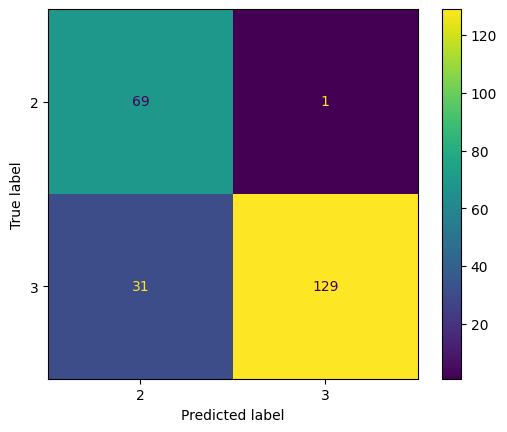

In [32]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=MN_FIFS_cMatrix, display_labels=MN_FIFS_model.classes_)
disp.plot()
plt.show()